#⚙️ Settings

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


In [ ]:
#importing libraries
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

#setting seeds for reproducibility
seed = 54
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#configuring plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# ⏳ Input and parameters

In [ ]:
#loading input data
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

#mapping numerical labels to cell types
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# removing the last 1800 images
X = X[:11959]
y = y[:11959]

In [ ]:
#converting labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

#splitting data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=y)

print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (9567, 96, 96, 3)
Training Label Shape: (9567, 8)
Validation Data Shape: (2392, 96, 96, 3)
Validation Label Shape: (2392, 8)


In [ ]:
#defining problem parameters
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
epochs = 20
batch_size = 64
learning_rate = 0.001

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Input Shape: (96, 96, 3)
Output Shape: 8
Epochs: 20
Batch Size: 64
Learning Rate: 0.001


# 🧠 Model

Masking Layer

In [ ]:
#adding decoration needed to serialize the model
@tf.keras.utils.register_keras_serializable()
class masking(tfk.Layer):
    def call(self,x):
        dim0, dim1, dim2, dim3 = x.shape

        #defining thresholds parameters
        c = [90, -20, 45]

        #assembling tresholds tensors
        v1 = np.array([[[130,50,120]]*dim2]*dim1).astype('uint8')
        v2 = np.array([[[180+c[2],90+c[2],150+c[2]]]*dim2]*dim1).astype('uint8')
        v3 = np.array([[[80+c[0],80+c[0],255]]*dim2]*dim1).astype('uint8')
        v4 = np.array([[[180+c[1],170+c[1],245+c[1]]]*dim2]*dim1).astype('uint8')

        #casting input images to integer values
        x_uint8 = tf.cast(x,tf.uint8)

        #comparing the images with each threshold tensor
        a1 = tf.reduce_all(tf.math.greater(x_uint8,tf.constant(v1)),axis=3)
        a2 = tf.reduce_all(tf.math.less(x_uint8,tf.constant(v2)),axis=3)
        a3 = tf.reduce_all(tf.math.less(x_uint8,tf.constant(v3)),axis=3)
        a4 = tf.reduce_all(tf.math.greater(x_uint8,tf.constant(v4)),axis=3)

        #combining the results to obtain the desired masking
        x_mask = tf.repeat(tf.expand_dims(tf.logical_or(tf.logical_or(tf.logical_and(a1,a2),a3),a4),axis=3),3,axis=3)

        #returning the mask as a float tensor (of just 0.s and 1.s)
        return tf.cast(x_mask,tf.float32)

Model creation

In [ ]:
def build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate, seed=seed):
    #setting seed and parameters
    tf.random.set_seed(seed)
    name='Overfitting'
    s=1

    #defing the inputs
    inputs = tfkl.Input(shape=input_shape, name='Input')

    #creating, "smoothing", and finally applying the mask
    x_mask = masking()(inputs)
    x_mask = tfkl.MaxPooling2D(pool_size=8,strides=8, name='mp1')(x_mask)
    x_mask = tfkl.UpSampling2D(size = (8,8), name='us1')(x_mask)
    x = tfkl.Multiply()([inputs,x_mask])

    #building the true convolutional part of the model
    x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', name='conv1')(x)
    x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', name='conv2')(x)

    x = tfkl.MaxPooling2D(pool_size=2,strides=2, name='mp2')(x)
    x = tfkl.SeparableConv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu' )(x)
    x = tfkl.SeparableConv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu' )(x)
    x = tfkl.BatchNormalization(name=f'{name}bn8{s}')(x)

    x = tfkl.MaxPooling2D(pool_size=2,strides=2, name='mp3')(x)
    x = tfkl.SeparableConv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu' )(x)
    x = tfkl.SeparableConv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu' )(x)
    x = tfkl.BatchNormalization(name=f'{name}bn9{s}')(x)

    x = tfkl.MaxPooling2D(pool_size=2,strides=2, name='mp4')(x)
    x = tfkl.SeparableConv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu' )(x)
    x = tfkl.SeparableConv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu' )(x)
    x = tfkl.BatchNormalization(name=f'{name}bn10{s}')(x)

    x = tfkl.MaxPooling2D(pool_size=2,strides=2, name='mp5')(x)
    x = tfkl.Dropout(rate = 0.2, seed=seed, name='Dropout1')(x)
    x = tfkl.SeparableConv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu' )(x)
    x = tfkl.SeparableConv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu' )(x)
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='conv3')(x)
    x = tfkl.BatchNormalization(name=f'{name}bn11{s}')(x)

    #building classification head with fully connected layers
    x = tfkl.MaxPooling2D(pool_size=2,strides=2, name='mp6')(x)
    x = tfkl.Dropout(rate = 0.2, seed=seed, name='Dropout5')(x)

    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dense(units=1152, name='Dense1', activation='tanh')(x)
    x = tfkl.Dropout(rate = 0.7, seed=seed, name='Dropout2')(x)

    x = tfkl.Dense(units=712, name='Dense2', activation='tanh')(x)
    x = tfkl.Dropout(rate = 0.5, seed=seed, name='Dropout3')(x)

    x = tfkl.Dense(units=440, name='Dense3', activation='tanh')(x)
    x = tfkl.Dropout(rate = 0.3, seed=seed, name='Dropout4')(x)

    outputs = tfkl.Dense(units=8, name='dense', activation='softmax')(x)

    #connecting input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    #compiling the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ masking (masking)      │ (None, 96, 96, 3)    │            0 │ Input[0][0]         │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ mp1 (MaxPooling2D)     │ (None, 12, 12, 3)    │            0 │ masking[0][0]       │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ us1 (UpSampling2D)     │ (None, 96, 96, 3)    │            0 │ mp1[0][0]           │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ multiply (Multiply)    │ (None, 96, 96, 3)    │            0 │ Input[0][0],        │    -    │
│                        │                      │              │ us1[0][0]           │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1 (Conv2D)         │ (None, 96, 96, 16)   │          448 │ multiply[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2 (Conv2D)         │ (None, 96, 96, 16)   │        2,320 │ conv1[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ mp2 (MaxPooling2D)     │ (None, 48, 48, 16)   │            0 │ conv2[0][0]         │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ separable_conv2d       │ (None, 48, 48, 16)   │          416 │ mp2[0][0]           │    Y    │
│ (SeparableConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ separable_conv2d_1     │ (None, 48, 48, 16)   │          416 │ separable_conv2d[0… │    Y    │
│ (SeparableConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Overfittingbn81        │ (None, 48, 48, 16)   │           64 │ separable_conv2d_1… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ mp3 (MaxPooling2D)     │ (None, 24, 24, 16)   │            0 │ Overfittingbn81[0]… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ separable_conv2d_2     │ (None, 24, 24, 32)   │          688 │ mp3[0][0]           │    Y    │
│ (SeparableConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ separable_conv2d_3     │ (None, 24, 24, 32)   │        1,344 │ separable_conv2d_2… │    Y    │
│ (SeparableConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Overfittingbn91        │ (None, 24, 24, 32)   │          128 │ separable_conv2d_3… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ mp4 (MaxPooling2D)     │ (None, 12, 12, 32)   │            0 │ Overfittingbn91[0]… │    -    │
├──────────────────────

 Total params: 2,515,272 (9.60 MB)

 Trainable params: 2,514,856 (9.59 MB)

 Non-trainable params: 416 (1.62 KB)

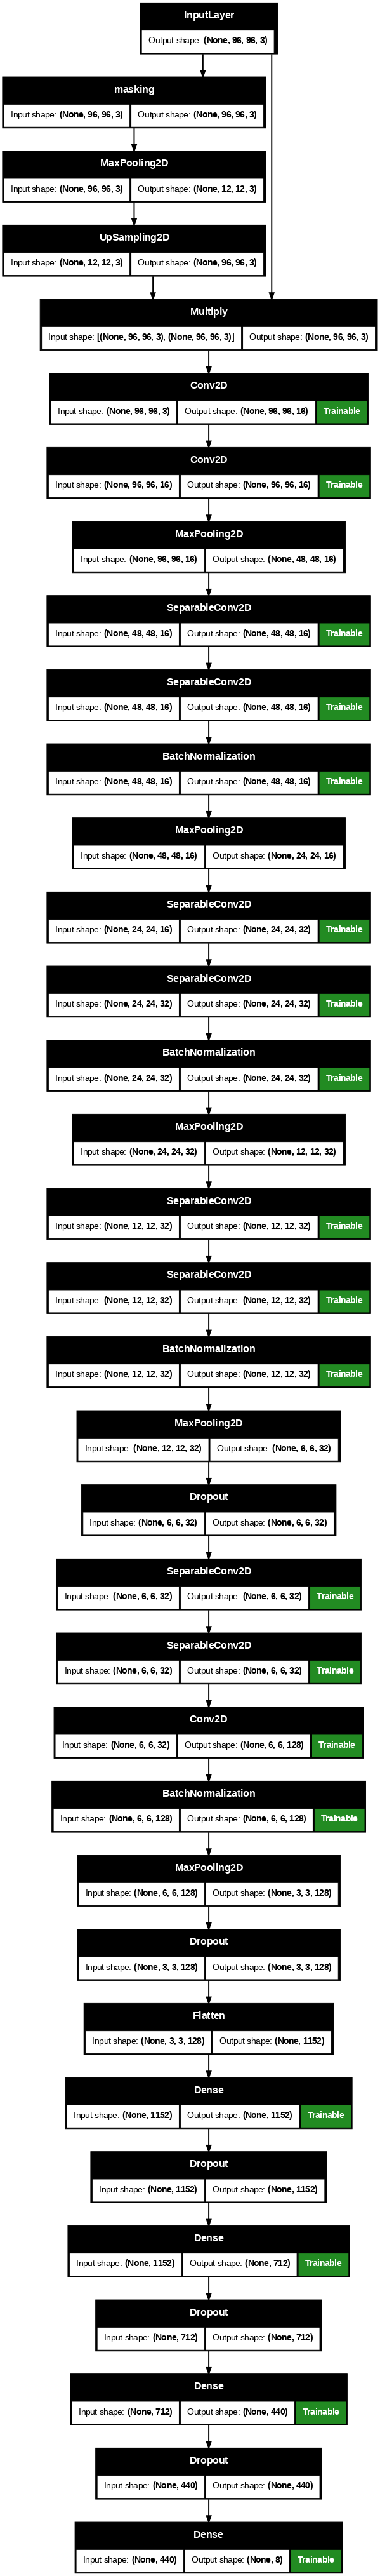

In [ ]:
#building the model and displaying its characteristics
model = build_model()
model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

# 🏋🏻‍♀️ Training

Callbaks

In [ ]:
#creating an EarlyStopping callback and adding it to the list of callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)
callbacks = [early_stopping]

Training with early stopping

In [ ]:
#training the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

#calculating and printing the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

#saving the trained model to a file with the accuracy included in the filename
model.save(f'OverfittingModel_{str(final_val_accuracy)}.keras')

del model

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 161ms/step - accuracy: 0.4114 - loss: 1.6094 - val_accuracy: 0.1823 - val_loss: 2.9715
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6664 - loss: 0.8660 - val_accuracy: 0.1948 - val_loss: 2.9908
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7706 - loss: 0.6310 - val_accuracy: 0.1693 - val_loss: 2.8463
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8336 - loss: 0.4617 - val_accuracy: 0.5360 - val_loss: 1.4454
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8621 - loss: 0.3990 - val_accuracy: 0.8273 - val_loss: 0.5694
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8752 - loss: 0.3658 - val_accuracy: 0.7212 - val_loss: 1.0695
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8836 - loss: 0.3302 - val_accuracy: 0.7989 - val_loss: 0.6750
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9041 - loss: 0.2937 

Plots

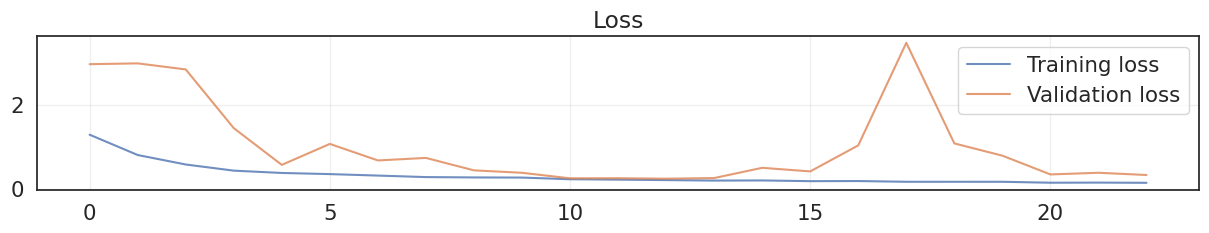

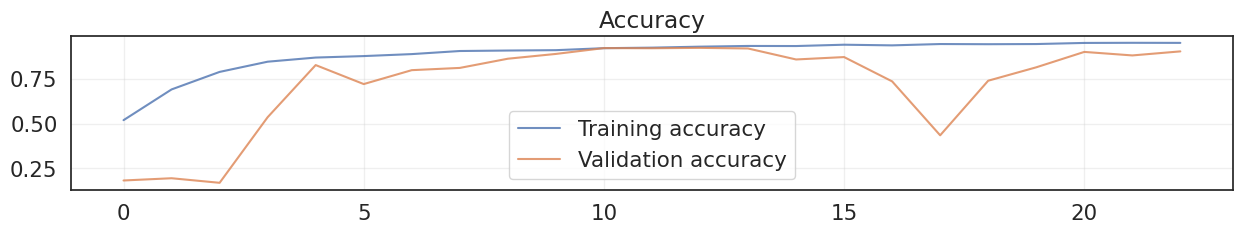

In [ ]:
#plotting training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

#plotting training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# 📲 Preparation for submission

Model class

In [ ]:
%%writefile model.py
import numpy as np
import glob

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

@tf.keras.utils.register_keras_serializable()
class masking(tfk.Layer):
    def call(self,x):
        dim0, dim1, dim2, dim3 = x.shape
        c = [90, -20, 45]
        v1 = np.array([[[130,50,120]]*dim2]*dim1).astype('uint8')
        v2 = np.array([[[180+c[2],90+c[2],150+c[2]]]*dim2]*dim1).astype('uint8')
        v3 = np.array([[[80+c[0],80+c[0],255]]*dim2]*dim1).astype('uint8')
        v4 = np.array([[[180+c[1],170+c[1],245+c[1]]]*dim2]*dim1).astype('uint8')
        x_uint8 = tf.cast(x,tf.uint8)
        a1 = tf.reduce_all(tf.math.greater(x_uint8,tf.constant(v1)),axis=3)
        a2 = tf.reduce_all(tf.math.less(x_uint8,tf.constant(v2)),axis=3)
        a3 = tf.reduce_all(tf.math.less(x_uint8,tf.constant(v3)),axis=3)
        a4 = tf.reduce_all(tf.math.greater(x_uint8,tf.constant(v4)),axis=3)
        x_mask = tf.repeat(tf.expand_dims(tf.logical_or(tf.logical_or(tf.logical_and(a1,a2),a3),a4),axis=3),3,axis=3)
        return tf.cast(x_mask,tf.float32)

class Model:
    def __init__(self):
        pattern = 'OverfittingModel*.keras'
        model_files = glob.glob(pattern)

        if model_files:
          self.neural_network = tfk.models.load_model(model_files[0], custom_objects={'masking': masking})
        else:
          print('No model file found.')

    def predict(self, X):
        preds = self.neural_network.predict(X)
        preds = np.argmax(preds, axis=-1)
        return preds

Writing model.py


Downloads

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'
!zip {filename} model.py 'OverfittingModel'_{str(final_val_accuracy)}.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 61%)
  adding: OverfittingModel_92.35.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>